## Подготовка датасета

### Загрузка

In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('./alzheimers_disease_data.csv')
raw_data

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6895,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,...,0,0,4.492838,1,0,0,0,0,1,XXXConfid
2145,6896,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,...,0,1,9.204952,0,0,0,0,0,1,XXXConfid
2146,6897,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,...,0,0,5.036334,0,0,0,0,0,1,XXXConfid
2147,6898,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,...,0,0,3.785399,0,0,0,0,1,1,XXXConfid


### Убираем лишние столбцы и делим датасет
> Делить на обучающую и тестовую выборки, по понятным причинам, не нужно

In [3]:
cleared_data = raw_data.drop(['PatientID', 'DoctorInCharge'], axis=1)

> Возьмём меньше данных ради экономии времени, иначе считает слишком уж долго

In [4]:
cleared_data = cleared_data.head(700)

In [5]:
non_categorial = []
for col in cleared_data.columns:
    print(f"{col}: {raw_data[col].dtype}")
    if raw_data[col].dtype == 'float64': non_categorial.append(col)

non_categorial.append('Age')

Age: int64
Gender: int64
Ethnicity: int64
EducationLevel: int64
BMI: float64
Smoking: int64
AlcoholConsumption: float64
PhysicalActivity: float64
DietQuality: float64
SleepQuality: float64
FamilyHistoryAlzheimers: int64
CardiovascularDisease: int64
Diabetes: int64
Depression: int64
HeadInjury: int64
Hypertension: int64
SystolicBP: int64
DiastolicBP: int64
CholesterolTotal: float64
CholesterolLDL: float64
CholesterolHDL: float64
CholesterolTriglycerides: float64
MMSE: float64
FunctionalAssessment: float64
MemoryComplaints: int64
BehavioralProblems: int64
ADL: float64
Confusion: int64
Disorientation: int64
PersonalityChanges: int64
DifficultyCompletingTasks: int64
Forgetfulness: int64
Diagnosis: int64


In [6]:
X = cleared_data.drop('Diagnosis', axis=1)
y = cleared_data['Diagnosis']

### Шкалирование

In [7]:
non_categorial

['BMI',
 'AlcoholConsumption',
 'PhysicalActivity',
 'DietQuality',
 'SleepQuality',
 'CholesterolTotal',
 'CholesterolLDL',
 'CholesterolHDL',
 'CholesterolTriglycerides',
 'MMSE',
 'FunctionalAssessment',
 'ADL',
 'Age']

In [8]:
# Шкалирование
from math import sqrt
def scale_list(series : list) -> pd.Series:
    n = len(series)
    mu = sum(series) / n
    s = sqrt( sum( (d - mu)**2 for d in series ) / (n-1))
    #print(f"n = {n} ; mu = {mu} ; s = {s}")
    return (series - mu) / s

def scale_df(df : pd.DataFrame, cols_for_scale : list[str]) -> pd.DataFrame:
    scaled_df = df.copy()
    for col in cols_for_scale:
        scaled_df[col] = scale_list(df[col])
    return scaled_df

X_scaled = scale_df(X, non_categorial)

## K-средних (KMeans)
> Эффективность будем измерять с помощью метрики $silhouette$. Это один из способов численно оценить модель (например метод обратных квадратов визуальный)
>
>Диапазон: `[-1:1]`, где `-1` -- наихудшая модель, `1` -- идеальная модель

> $Silhouette$ для одного объекта $x$:
> $$silhouette(x)=\frac{b(x)-a(x)}{max(a(x), b(x))}$$
> $a(x)$ -- **внутрикластерное расстояние**, среднее расстояние от $x$ до всех дргугих объектов в этом кластере
>
> $b(x)$ -- **межкластерное расстояние**, среднее расстояние от $x$ до всех дргугих объектов в других кластерах

> То есть, хорошая модель -- такая, где объекты одного кластера близко, а сами кластеры далеко друг от друга.
> 
> Метрика $silhouette$ для модели -- среднее между $silhouette$ для всех экземпляров.

### Модель

In [9]:
import numpy as np
from math import sqrt

In [10]:
# Квадрат расстояния между точками
def sqr_distance(a:list[float], b:list[float]) -> float:
    aa = np.array(a)
    bb = np.array(b)
    return np.sum( (bb-aa)**2 )

# Усреднённая точка
def points_mean(points:list[list[float]]) -> list[float]:
    return np.mean( points, axis=0).tolist()

# Матрица расстояний между точками
def get_distances_matrix(X):
    n = len(X)
    distances = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            dist = sqrt( sqr_distance(X[i], X[j]) )
            distances[i, j] = dist
            distances[j, i] = dist
    return distances

In [11]:
def silhouette_score(k, X:list[list[float]], y_pred) -> float:
    #if self.means is None: raise Exception('Модель ещё не обучена')

    n = len(X)
    #y = self.predict(X)
    y = y_pred
    
    # Матрица расстояний между точками
    distances = get_distances_matrix(X)
    
    silhouette_scores = []
    for i in range(n):
        # Метка этого кластера
        label = y[i]
        # Индексы точек этого кластера
        cluster_points_i = [j for j in range(n) if y[j] == label and j != i]

        # a(i) -- среднее расстояние до других точек в кластере
        if cluster_points_i:
            a_i = np.mean( [distances[i, j] for j in cluster_points_i] )
        else:
            a_i = 0

        b_is = []
        # Проходимся по другим меткам и записываем среднее расстояние до точек
        other_labels = set(range(k)) - {label}
        for other_label in other_labels:
            other_cluster_points_i = [j for j in range(n) if y[j] == other_label]
            if other_cluster_points_i:
                b_is.append( np.mean( [distances[i, j] for j in other_cluster_points_i] ) )

        if b_is:
            b_i = min(b_is)
        else:
            b_i = a_i

        silhouette_i = (b_i - a_i) / max(a_i, b_i)
        silhouette_scores.append(silhouette_i)
    return np.mean( silhouette_scores )

In [12]:
class KMeans:
    k : int
    random_state : int
    means : list
    
    # Создание модели с параметрами
    def __init__(self, n_clusters, random_state=None):
        if n_clusters < 2: raise Exception('k must be >= 2')
        #
        self.k = n_clusters # число кластеров
        self.random_state = random_state # сид рандома
        self.means = None # центры кластеров

    # Классификация экземпляра данных
    # (расстояние до ближайшего кластера)
    ## Returns: индекс ближайшего кластера
    def classify_point(self, point:list[float]) -> int:
        # Пробегаем по индексам всех цетров и ищем минимальное расстояние
        return min( range(self.k), key = lambda i: sqr_distance(point, self.means[i]) )

    # Список меток для каждой точки X
    def predict(self, X:list[list[float]]) -> list[float]:
        return [ self.classify_point(p) for p in X ]
    
    # Создание классификации
    ## X -- список векторов (точек)
    ## Returns: y_pred
    def fit(self, X:list[list[float]]) -> list[float]:
        # Устанавливаем сид рандома если он установлен
        if self.random_state is not None: 
            np.random.seed(self.random_state)
            
        # k случайных точек
        indices = np.random.choice(len(X), self.k, replace=False)
        self.means = [X[i] for i in indices]
        
        preds = None # Предыдущая классификация всех точек
        while True:
            # Классифицируем все точки
            new_preds = self.predict(X)
            # Если классификация не отличается, мы пришли к ответу
            if new_preds == preds: return new_preds # (Да, так работает, python умный)
            
            preds = new_preds            
            # Двигаем центры кластеров
            for i in range(self.k):
                # Точки кластера i
                cluster_points = [ p for p,a in zip(X, preds) if a == i]
                # Если кластер не пустой, смещаем центр
                if cluster_points:
                    self.means[i] = points_mean(cluster_points)
    
    def silhouette_score(self, X):
        return silhouette_score( self.k, X, self.predict(X) )

    def squared_error(self, X):
        y_pred = self.predict(X)
        total_err = 0
        #print(f'means ({len(self.means)}): {self.means}')
        for point, label in zip( X, y_pred ):
            total_err += sqr_distance(point, self.means[label]) 
        return total_err

In [13]:
# # Использование:
# model = KMeans(k, random_state=42)
# y_pred = model.fit( X_scalsed )
# # либо
# model.fit( X_scalsed )
# y_pred = model.predict( X_scalsed )

### Обучение (выбор числа кластеров)

In [14]:
correct_X = np.array(X_scaled)

In [15]:
n_clusters = range(2, 11)

# Обёртка для удобного хранения данных
class KMeansData:
    # 
    def __init__(self, k:int, X, random_state=None):
        self.k = k
        self.model = KMeans(k, random_state)
        self.y_pred = self.model.fit(X)
        self.silhouette = self.model.silhouette_score(X)
        self.sqr_err = self.model.squared_error(X)

models = []
for k in n_clusters:
    print(f'[ Модель для {k} кластеров ]')
    model = KMeansData(k, correct_X, random_state=42)
    print(f'silhouette: {model.silhouette}')
    print(f'squared error: {model.sqr_err}')
    models.append(model)
    print()

[ Модель для 2 кластеров ]
silhouette: 0.41419009041651916
squared error: 338383.56278646097

[ Модель для 3 кластеров ]
silhouette: 0.379964096897985
squared error: 248643.1231357787

[ Модель для 4 кластеров ]
silhouette: 0.36603332711883624
squared error: 177155.28336146811

[ Модель для 5 кластеров ]
silhouette: 0.35540355247440375
squared error: 142142.69522748629

[ Модель для 6 кластеров ]
silhouette: 0.3543657189582935
squared error: 114085.22839566505

[ Модель для 7 кластеров ]
silhouette: 0.3327999185247153
squared error: 101118.00676058963

[ Модель для 8 кластеров ]
silhouette: 0.32205080903827155
squared error: 93226.36301438484

[ Модель для 9 кластеров ]
silhouette: 0.3403114090308861
squared error: 81543.7111640125

[ Модель для 10 кластеров ]
silhouette: 0.32427533411454385
squared error: 73841.22516129418



In [16]:
import matplotlib.pyplot as plt

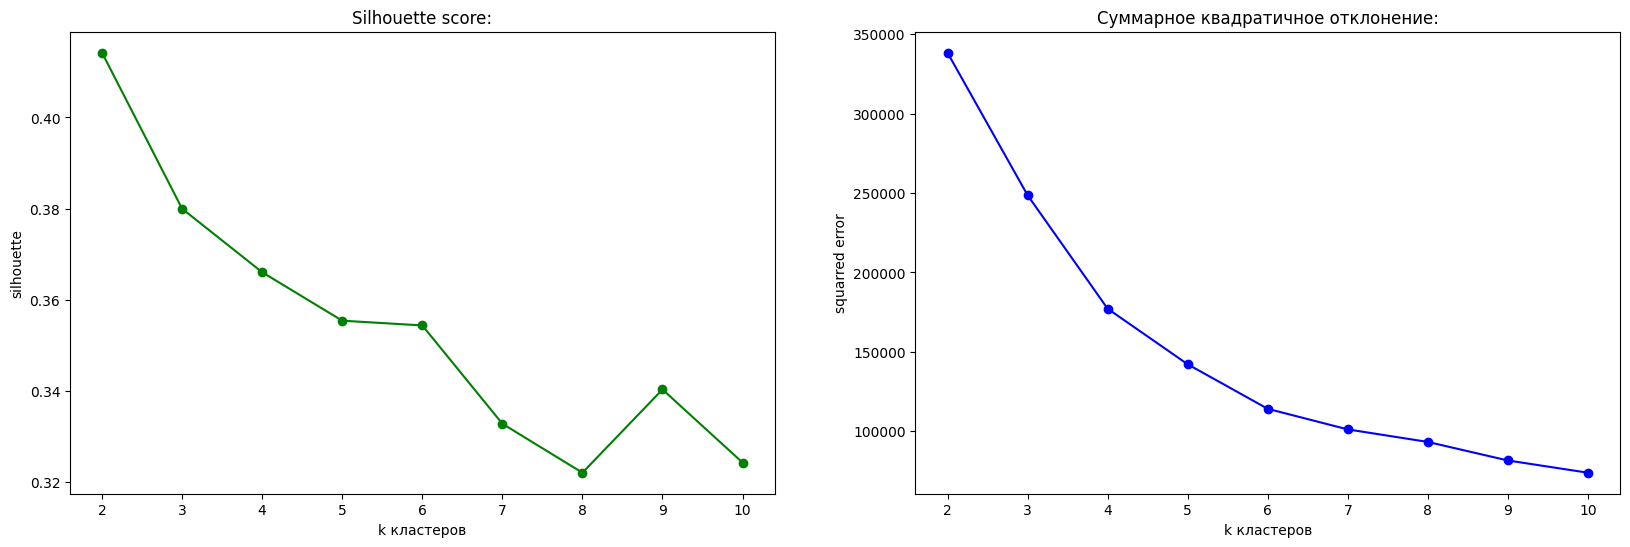

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

silhouettes = [ model.silhouette for model in models]
sqrerrs = [ model.sqr_err for model in models]

#plt.figure(figsize=(10, 6))
axes[0].plot(n_clusters, silhouettes, 'o-', color="g")
axes[0].set_xticks(n_clusters)
axes[0].set_xlabel('k кластеров')
axes[0].set_ylabel('silhouette')
axes[0].set_title('Silhouette score:')

axes[1].plot(n_clusters, sqrerrs, 'o-', color="b")
axes[1].set_xticks(n_clusters)
axes[1].set_xlabel('k кластеров')
axes[1].set_ylabel('squarred error')
axes[1].set_title('Суммарное квадратичное отклонение:')

plt.show()

In [27]:
best_k1_0 = 2
best_k1_1 = 3
best_k1_2 = 4
best_model1_0 = [ m for m in models if m.k == best_k1_0 ][0]
best_model1_1 = [ m for m in models if m.k == best_k1_1 ][0]
best_model1_2 = [ m for m in models if m.k == best_k1_2 ][0]

### Вывод:
> 1) **Метод локтя** -- излом (*"локоть"*) примерно при `4` и `6` кластерах. После `7` уменьшение замедляется
>    
> 2) **Silhoette метрика** -- самая высокая при `2` кластерах (что логично, ведь изначальных меток две). При 3-4 метрика тоже неплохая. После 6 резкое снижение
> 
> **Итог:** `4` -- оптимальное число кластеров. Для финального сравнения возьмём также 3

## Восходящая кластеризация
> **Идея:**
> - Создаём кластер из каждой точки
> - Объединяем два ближайших кластера
> - Повторяем пока кластеров не станет два
> - Откатываем до нужного количества кластеров


In [19]:
class AgglomerativeClustering:
    #
    def __init__(self, distance_algorithm=np.min):
        self.distance_algorithm = distance_algorithm
        self.merges = None
        self.clusters = None

    # Расстояние между кластерами
    def get_distance(self, cluster_a:list, cluster_b:list, distances_matrix) -> float:
        distances = []
        for a in cluster_a:
            for b in cluster_b:
                distances.append( distances_matrix[ a, b ] )
        return self.distance_algorithm( distances )

    # Обучение
    def fit(self, X:list[list[float]]):
        n_points = len(X)
        self.n_points = n_points
        
        # Кластеры из всех точек
        # Каждый кластер это set с индексами точек
        clusters = [ {i} for i in range(n_points) ]

        # Матрица расстояний
        distances = get_distances_matrix(X)

        # Проводим слияния пока не останется два кластера
        merges = []
        while len(clusters) > 2:
            print(len(clusters), end=('\n' if len(clusters)%10==0 else ' '))
            min_distance = float('+inf') # Да, так работает x2
            neardest_points = (None, None)

            for i, _ in enumerate(clusters):
                for j in range(i+1, len(clusters)):
                    distance = self.get_distance( clusters[i], clusters[j], distances )
                    if distance < min_distance:
                        min_distance = distance
                        neardest_points = (i, j)
            
            i, j = neardest_points
            new_cluster = clusters[i].union(clusters[j])
            
            merges.append({
                'clusters': [ clusters[i].copy(), clusters[j].copy() ],
                'distance': min_distance,
                'new_cluster': new_cluster,
            })

            # Удаляем старые кластеры
            clusters = [ c for l, c in enumerate(clusters) if l not in [i, j] ]
            # Добавляем новый элемент
            clusters.append(new_cluster)

        self.merges = merges
        self.clusters = clusters
        
        return self

    def undo_merges(self, n_clusters):
        # Слияний нужно отменить
        merges_to_undo = n_clusters - 2

        # Изначальные кластеры (2)
        clusters = self.clusters.copy()

        for i in range(merges_to_undo):
            # Итерируем с конца
            merge = self.merges[ -i-1 ]
            # Слившиеся кластеры
            cluster_a, cluster_b = merge['clusters']
            # Образовавшийся
            new_cluster = cluster_a.union(cluster_b)
            #new_cluster = merge['new_cluster']
            
            # Осталось удалить новый и добавить старые
            # for j, cl in enumerate(clusters):
            #     if cl == new_cluster:
            #         clusters.pop(j)
            #         clusters.append(cluster_a)
            #         clusters.append(cluster_b)
            #         break
            clusters.remove(new_cluster)
            clusters.append(cluster_a)
            clusters.append(cluster_b)
        return clusters

    def predict(self, n_clusters, X):
        clusters = self.undo_merges(n_clusters)
        
        y_pred = np.zeros(len(X))
        for cluster_label, cluster in enumerate(clusters):
            for point_i in cluster:
                y_pred[point_i] = cluster_label
        return y_pred
        
    def silhouette_score(self, n_clusters, X):
        return silhouette_score( n_clusters, X, self.predict(n_clusters, X) )

    def squared_error(self, n_clusters, X):
        y_pred = self.predict(n_clusters, X)

        means = []
        labels = range(n_clusters)
        # Находим means
        for label in labels:
            points = [ X[i] for i, y in enumerate(y_pred) if y==label ]
            means.append( points_mean( points ) )
        
        total_err = 0
        #print(f'means ({len(self.means)}): {self.means}')
        for point, label in zip( X, y_pred ):
            total_err += sqr_distance(point, means[int(label)]) 
        return total_err

In [20]:
# Создаём и обучаем модель
best_model2 = AgglomerativeClustering(distance_algorithm=np.mean)
best_model2 = best_model2.fit(correct_X)

700
699 698 697 696 695 694 693 692 691 690
689 688 687 686 685 684 683 682 681 680
679 678 677 676 675 674 673 672 671 670
669 668 667 666 665 664 663 662 661 660
659 658 657 656 655 654 653 652 651 650
649 648 647 646 645 644 643 642 641 640
639 638 637 636 635 634 633 632 631 630
629 628 627 626 625 624 623 622 621 620
619 618 617 616 615 614 613 612 611 610
609 608 607 606 605 604 603 602 601 600
599 598 597 596 595 594 593 592 591 590
589 588 587 586 585 584 583 582 581 580
579 578 577 576 575 574 573 572 571 570
569 568 567 566 565 564 563 562 561 560
559 558 557 556 555 554 553 552 551 550
549 548 547 546 545 544 543 542 541 540
539 538 537 536 535 534 533 532 531 530
529 528 527 526 525 524 523 522 521 520
519 518 517 516 515 514 513 512 511 510
509 508 507 506 505 504 503 502 501 500
499 498 497 496 495 494 493 492 491 490
489 488 487 486 485 484 483 482 481 480
479 478 477 476 475 474 473 472 471 470
469 468 467 466 465 464 463 462 461 460
459 458 457 456 455 454 453 452 451 

In [21]:
# Резкое увеличение расстояния слияния => оптимальное k 
def find_best_k(merges, part_of_max=0.7):
    # Расстояния слияний
    distances = [merge['distance'] for merge in merges]
    # Изменения расстояний
    distance_changes = [distances[i+1] - distances[i] for i in range(len(distances)-1)]

    # Берём не максимальное изменение, а допустимую долю от него
    max_change = max(distance_changes)
    good_change = part_of_max * max_change

    best = []
    for i, change in enumerate(distance_changes):
        if change > good_change:
            # Количество кластеров -- количество точек - слияний
            best.append( len(distances) - i )
    return best

best_k2s = find_best_k(best_model2.merges)

In [22]:
best_k2s

[5, 2]

In [23]:
best_k2_1 = best_k2s[-1]
best_k2_2 = best_k2s[-2]

## Сравнение моделей
> **Количественное** -- значит конкретное числовое выражение

In [28]:
pd.DataFrame([
    {
        'algorithm': 'KMeans',
        'k': best_k1_0,
        'silhouette score': best_model1_0.silhouette,
        'sqr error': best_model1_0.sqr_err,
    },
    {
        'algorithm': 'KMeans',
        'k': best_k1_1,
        'silhouette score': best_model1_1.silhouette,
        'sqr error': best_model1_1.sqr_err,
    },
    {
        'algorithm': 'KMeans',
        'k': best_k1_2,
        'silhouette score': best_model1_2.silhouette,
        'sqr error': best_model1_2.sqr_err,
    },
    {
        'algorithm': 'Agglomirative',
        'k': best_k2_1,
        'silhouette score': best_model2.silhouette_score(best_k2_1, correct_X),
        'sqr error': best_model2.squared_error(best_k2_1, correct_X),
    },
    {
        'algorithm': 'Agglomirative',
        'k': 3,
        'silhouette score': best_model2.silhouette_score(3, correct_X),
        'sqr error': best_model2.squared_error(3, correct_X),
    },
    {
        'algorithm': 'Agglomirative',
        'k': 4,
        'silhouette score': best_model2.silhouette_score(4, correct_X),
        'sqr error': best_model2.squared_error(4, correct_X),
    },
    {
        'algorithm': 'Agglomirative',
        'k': best_k2_2,
        'silhouette score': best_model2.silhouette_score(best_k2_2, correct_X),
        'sqr error': best_model2.squared_error(best_k2_2, correct_X),
    },
])

,algorithm,k,silhouette score,sqr error
0,KMeans,2,0.414190,338383.562786
1,KMeans,3,0.379964,248643.123136
2,KMeans,4,0.366033,177155.283361
3,Agglomirative,2,0.361542,387768.112656
4,Agglomirative,3,0.325591,276973.241500
5,Agglomirative,4,0.306889,210300.021903
6,Agglomirative,5,0.308665,164018.864079


## Вывод
> С практической точки зрения, мы разделили пациентов на несколько групп. Исследования этих групп и поиск закономерностей могут помочь выявить заболевания или другие медицинские данные.
> 
> Оптимальное разделение 3-4 группы